# EDA on CORD-19 Dataset:
In this notebook I provided a comprehensive view of the CORD-19 dataset, uncovering patterns related to publication years, sources, and the structure of research papers.

**Data Loading & Inspection:**
Loaded the CORD-19 dataset and explored its structure, checking for missing values.

**Visualizations:**
Visualized publication sources, publication year distribution, top journals, abstract length, and license types.

**Text Analysis:**
Extracted and cleaned text from abstracts and body text, then calculated word and character counts.

**Section Analysis:**
Identified and visualized the most common document sections (e.g., Introduction, Methods).

**Word Cloud & Frequency:**
Generated a word cloud and identified the top 20 most frequent words after removing stop words

**Next Steps:**
Feature engineering, Modeling and Time Series

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import re
from collections import Counter
from wordcloud import WordCloud


In [23]:
df = pd.read_csv("metadata.csv")

C:\Users\MUZEEZA SYED\AppData\Local\Temp\ipykernel_4456\195187386.py:1: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("metadata.csv")


Here I will display a summary of the dataset including column types, non-null counts, and a preview of the first 5 rows

In [24]:
print("Dataset Info:")
df.info()
print("\nFirst 5 Rows:")
print(df.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056660 entries, 0 to 1056659
Data columns (total 19 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   cord_uid          1056660 non-null  object 
 1   sha               373766 non-null   object 
 2   source_x          1056660 non-null  object 
 3   title             1056157 non-null  object 
 4   doi               656780 non-null   object 
 5   pmcid             389571 non-null   object 
 6   pubmed_id         498932 non-null   object 
 7   license           1056660 non-null  object 
 8   abstract          821116 non-null   object 
 9   publish_time      1054846 non-null  object 
 10  authors           1032791 non-null  object 
 11  journal           969338 non-null   object 
 12  mag_id            0 non-null        float64
 13  who_covidence_id  482935 non-null   object 
 14  arxiv_id          14249 non-null    object 
 15  pdf_json_files    373766 non-null  

Next here will display the total number of missing (null) values in each column of the dataset

In [25]:
print("\nMissing Values:")
print(df.isnull().sum())



Missing Values:
cord_uid                  0
sha                  682894
source_x                  0
title                   503
doi                  399880
pmcid                667089
pubmed_id            557728
license                   0
abstract             235544
publish_time           1814
authors               23869
journal               87322
mag_id              1056660
who_covidence_id     573725
arxiv_id            1042411
pdf_json_files       682894
pmc_json_files       740918
url                  369726
s2_id                 80192
dtype: int64


This displays the count of unique values in the 'source_x' column to understand the distribution of data sources

In [26]:
print("\nUnique Sources:")
print(df['source_x'].value_counts())


Unique Sources:
source_x
WHO                                    450459
Medline; PMC                           150593
Medline                                131531
PMC                                     80192
Medline; PMC; WHO                       65968
Elsevier; Medline; PMC                  49318
Medline; WHO                            43928
Elsevier; Medline; PMC; WHO             19794
MedRxiv; WHO                            13756
ArXiv                                   13176
Elsevier; PMC                            8550
Elsevier; PMC; WHO                       6593
PMC; WHO                                 6136
MedRxiv                                  4754
BioRxiv; WHO                             3746
BioRxiv                                  3600
MedRxiv; Medline; PMC; WHO                957
BioRxiv; Medline; PMC; WHO                704
BioRxiv; Medline; WHO                     403
MedRxiv; Medline; WHO                     389
Elsevier                                  371
BioRxiv;

Here I extracted the publication year from the 'publish_time' column and created a histogram to visualize its distribution. Invalid dates are coerced to NaT, then dropped before plotting.

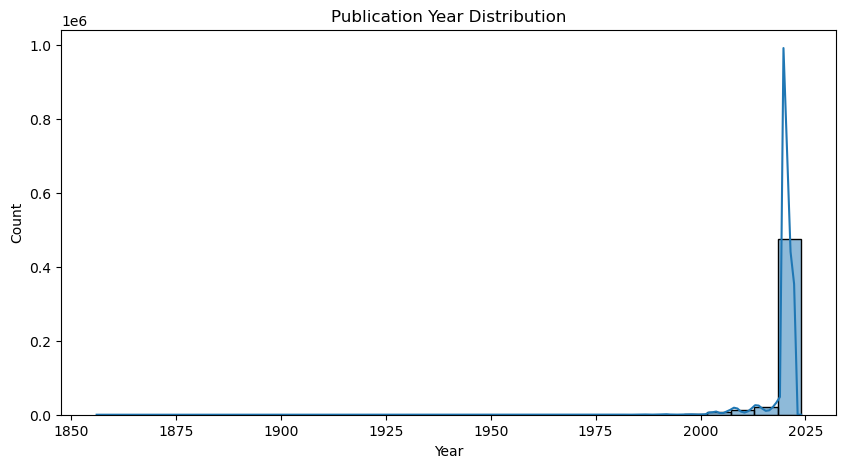

In [27]:
df['publish_year'] = pd.to_datetime(df['publish_time'], errors='coerce').dt.year
plt.figure(figsize=(10,5))
sns.histplot(df['publish_year'].dropna(), bins=30, kde=True)
plt.title("Publication Year Distribution")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

Next I will display the top 10 most frequent journals in the dataset and visualize them using a bar chart


Top 10 Journals:
journal
PLoS One                           9953
bioRxiv                            8961
Int J Environ Res Public Health    8201
BMJ                                6928
Sci Rep                            5935
Cureus                             4212
Reactions Weekly                   3891
Front Psychol                      3541
BMJ Open                           3515
Front Immunol                      3442
Name: count, dtype: int64


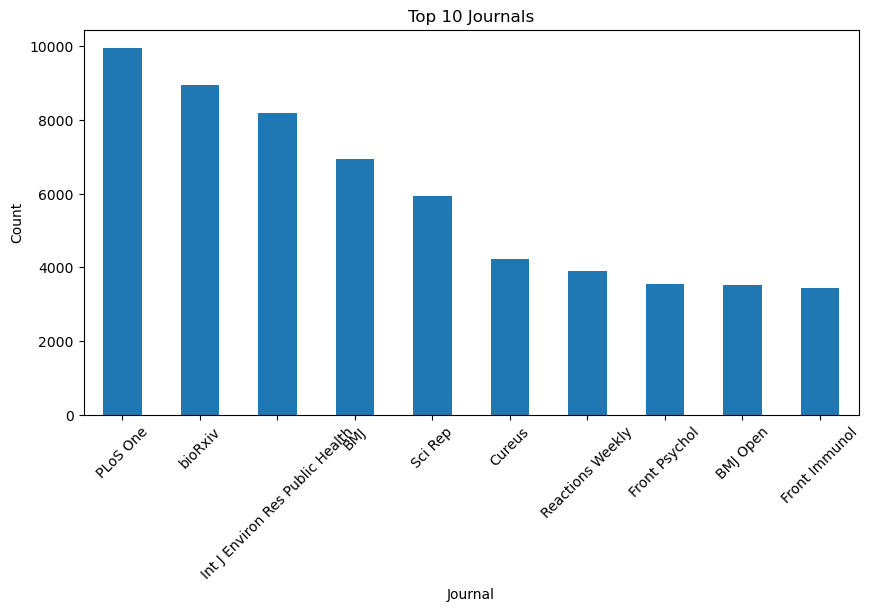

In [28]:
print("\nTop 10 Journals:")
print(df['journal'].value_counts().head(10))
plt.figure(figsize=(10,5))
df['journal'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Journals")
plt.xlabel("Journal")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

I calculated the length of each abstract and created a histogram to visualize the distribution of abstract lengths

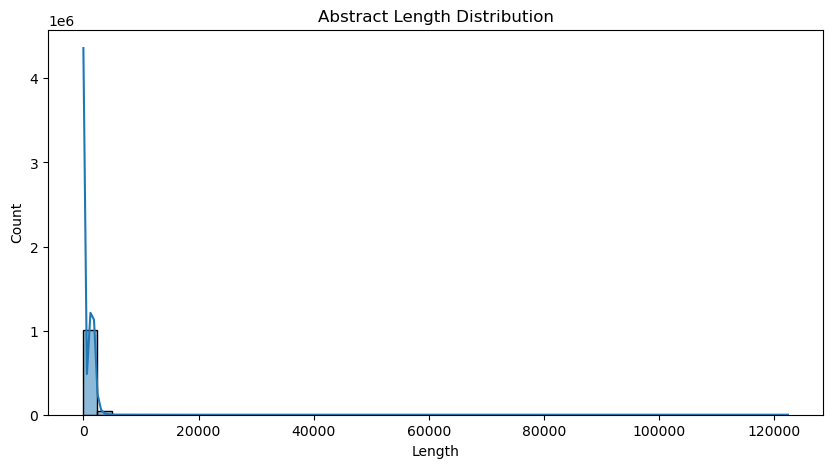

In [29]:
df['abstract_length'] = df['abstract'].astype(str).apply(len)
plt.figure(figsize=(10,5))
sns.histplot(df['abstract_length'], bins=50, kde=True)
plt.title("Abstract Length Distribution")
plt.xlabel("Length")
plt.ylabel("Count")
plt.show()

Here I will display the distribution of license types in the dataset and visualize it using a bar chart


License Distribution:
license
unk            601506
no-cc          165314
cc-by          160955
els-covid       32382
cc-by-nc        26046
cc-by-nc-nd     20226
medrxiv         17970
arxiv           13698
biorxiv          7841
cc-by-nc-sa      6549
cc0               972
green-oa          896
cc-by-nd          886
bronze-oa         749
hybrid-oa         256
cc-by-sa          172
pd                145
gold-oa            97
Name: count, dtype: int64


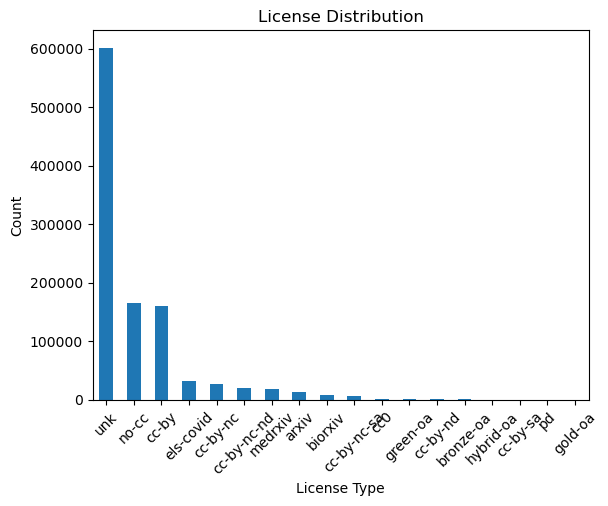

In [30]:
print("\nLicense Distribution:")
print(df['license'].value_counts())
df['license'].value_counts().plot(kind='bar')
plt.title("License Distribution")
plt.xlabel("License Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

This function is designed to handle file reading and errors gracefully. The Function only read up to 100 valid JSON files from a list of paths, skipping non-existent or invalid files

In [31]:
def read_json_files(paths):
    """Reads up to 100 valid JSON files from a list of paths, skipping non-existent or invalid ones."""
    json_data = []  # List to store the successfully loaded JSON data
    skipped_files = []  # List to keep track of paths that couldn't be processed

    for path in paths:
        path = str(path).strip()  # Clean the path by removing extra spaces
        if not path or path.lower() == "nan" or not path.endswith(".json"):  # Skip invalid paths or non-JSON files
            continue
        if os.path.exists(path):  # Check if the file exists
            try:
                with open(path, "r", encoding="utf-8") as f:  # Open the file in read mode with UTF-8 encoding
                    json_data.append(json.load(f))  # Load the JSON content and append it to the list
            except json.JSONDecodeError as e:  # Catch JSON decoding errors and print a warning
                print(f"⚠️ JSON decode error in file {path}: {e}")
        else:
            skipped_files.append(path)  # Add the path to the skipped files list if the file doesn't exist

        if len(json_data) >= 100:  # Stop reading files after 100 valid JSON files
            break

    print(f"🔍 Skipped {len(skipped_files)} missing files.")  # Print a message about skipped files
    return json_data  # Return the successfully loaded JSON data


Combine the 'pdf_json_files' and 'pmc_json_files' columns into a single string, separated by a semicolon, and store it in a new column 'all_json_files'

In [32]:
df["all_json_files"] = df[["pdf_json_files", "pmc_json_files"]].astype(str).agg(";".join, axis=1)

Split the 'all_json_files' column by semicolons, flatten the list into individual file paths, remove any NaN values, strip any leading or trailing spaces from the paths, and convert the result into a list of file paths.

In [33]:
all_paths = (
    df["all_json_files"]
    .str.split(";")
    .explode()
    .dropna()
    .map(str.strip)
    .tolist()
)

Here I created a new variable 'limited_paths' that is a copy of the list 'all_paths'

In [34]:
limited_paths = all_paths

Next, Read up to 100 valid JSON files from the 'limited_paths' list, skipping invalid or non-existent files and storing the successful JSON content in 'json_contents'.

In [35]:
json_contents = read_json_files(limited_paths)

# Print the total number of successfully read JSON files
print(f"\n✅ Total JSON files successfully read: {len(json_contents)}")

🔍 Skipped 717012 missing files.

✅ Total JSON files successfully read: 0


Here I wrote a function to extract and concatenate text from 'abstract' and 'body_text' fields of a JSON object.
Handles both list and string types for these fields and concatenates the extracted text.

In [36]:
def extract_text(json_obj):
    """
    Extracts and concatenates text from the 'abstract' and 'body_text' fields.
    """
    text_parts = []  # List to hold the extracted text parts

    # Process abstract field (it can be a list or a string)
    if "abstract" in json_obj:
        if isinstance(json_obj["abstract"], list):  # If 'abstract' is a list, process each item
            for item in json_obj["abstract"]:
                if isinstance(item, str):  # If the item is a string, add it to text_parts
                    text_parts.append(item)
                elif isinstance(item, dict):  # If the item is a dict, extract the 'text' key value
                    text_parts.append(item.get("text", ""))
        elif isinstance(json_obj["abstract"], str):  # If 'abstract' is a string, add it directly
            text_parts.append(json_obj["abstract"])
    
    # Process body_text field (usually a list of sections)
    if "body_text" in json_obj:
        if isinstance(json_obj["body_text"], list):  # If 'body_text' is a list, process each item
            for item in json_obj["body_text"]:
                if isinstance(item, dict):  # If the item is a dict, extract the 'text' key value
                    text_parts.append(item.get("text", ""))
                elif isinstance(item, str):  # If the item is a string, add it to text_parts
                    text_parts.append(item)
        elif isinstance(json_obj["body_text"], str):  # If 'body_text' is a string, add it directly
            text_parts_

Iterate over each JSON object in 'json_contents' to extract key information and process it into a structured format

In [39]:
records = []  # List to store processed records for each paper

for json_obj in json_contents:
    # Extract paper_id and title from metadata (set default values if missing)
    paper_id = json_obj.get("paper_id", "Unknown")
    metadata = json_obj.get("metadata", {})
    title = metadata.get("title", "No Title")
    
    # Extract authors as a comma-separated string, handling both dictionary and string formats
    authors_list = metadata.get("authors", [])
    if isinstance(authors_list, list) and authors_list:
        authors = []
        for a in authors_list:
            if isinstance(a, dict):  # If the author is a dictionary, use the 'name' key or combine first and last names
                if "name" in a:
                    authors.append(a["name"])
                else:
                    fname = a.get("first", "")
                    lname = a.get("last", "")
                    authors.append((fname + " " + lname).strip())
            elif isinstance(a, str):  # If the author is a string, add it directly
                authors.append(a)
        authors = ", ".join(authors)  # Combine all authors into a comma-separated string
    else:
        authors = "Unknown"  # Set "Unknown" if authors are missing or not in list format
    
    # Extract combined text (abstract + body_text) using the 'extract_text' function and calculate word/character counts
    text = extract_text(json_obj)
    word_count = len(re.findall(r'\w+', text))  # Count the number of words using regex
    char_count = len(text)  # Count the total number of characters in the text
    
    # Extract sections from 'body_text' (if available) and join them into a comma-separated string
    sections = []
    if "body_text" in json_obj and isinstance(json_obj["body_text"], list):
        for item in json_obj["body_text"]:
            if isinstance(item, dict):
                sec = item.get("section", "").strip()  # Get the section name from each item (if available)
                if sec:
                    sections.append(sec)
    sections_str = ", ".join(set(sections)) if sections else "N/A"  # Combine sections into a string or "N/A" if none
    
    # Append a record with extracted information for the current paper
    records.append({
        "paper_id": paper_id,
        "title": title,
        "authors": authors,
        "word_count": word_count,
        "char_count": char_count,
        "sections": sections_str,
        "text": text  # Add the full extracted text for later analysis
    })

# Convert the list of processed records into a DataFrame for further analysis or storage
eda_df = pd.DataFrame(records)


Here I will display the 'eda_df' DataFrame, which contains structured information extracted from the JSON files.This DataFrame includes columns like paper_id, title, authors, word count, character count, sections, and the full text.

In [40]:
eda_df

""


A great way to verify that the data was loaded and structured correctly. Here I displayed basic information about the 'eda_df' DataFrame, including column names, data types, and non-null counts. Then print the first 5 rows to get a quick preview of the data.

In [41]:
print("Dataset Information:")
print(eda_df.info())
print("\nFirst 5 rows:")
print(eda_df.head())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Empty DataFrame
None

First 5 rows:
Empty DataFrame
Columns: []
Index: []


Created a histogram with a KDE (Kernel Density Estimate) overlay to visualize the distribution of word counts across all JSON documents in the 'eda_df' DataFrame.

In [43]:
plt.figure(figsize=(10,6))
sns.histplot(eda_df["word_count"], bins=20, kde=True)
plt.title("Distribution of Word Count in JSON Files")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

KeyError: 'word_count'

<Figure size 1000x600 with 0 Axes>

This time created a histogram with a KDE overlay to visualize the distribution of character counts across all documents in the 'eda_df' DataFrame.

In [45]:
plt.figure(figsize=(10,6))
sns.histplot(eda_df["char_count"], bins=20, kde=True)
plt.title("Distribution of Character Count in JSON Files")
plt.xlabel("Character Count")
plt.ylabel("Frequency")
plt.show()

KeyError: 'char_count'

<Figure size 1000x600 with 0 Axes>

To visualize oand further analyze the most common sections across papers, Extracted all section names from the 'body_text' field of each JSON object in 'json_contents'. Next normalize section names to lowercase and store them in a list for frequency analysis

In [44]:

all_sections = []
for json_obj in json_contents:
    if "body_text" in json_obj and isinstance(json_obj["body_text"], list):
        for item in json_obj["body_text"]:
            if isinstance(item, dict):
                sec = item.get("section", "").strip().lower()  # Normalize section name to lowercase
                if sec:
                    all_sections.append(sec)

# Convert the list of section names into a DataFrame
section_df = pd.DataFrame(all_sections, columns=["section"])

# Group the DataFrame by section name and count occurrences to get frequency of each section
grouped_sections = section_df.groupby("section").size().reset_index(name="frequency")

# Sort the grouped sections by frequency in descending order for better visualization
grouped_sections = grouped_sections.sort_values(by="frequency", ascending=False)

This gives a quick look at the most common structural elements used in the papers which is great for understanding document formatting trends

In [46]:
# Select the top N most frequent sections for analysis and visualization
top_n = 10
plot_df = grouped_sections.head(top_n)

# Print the DataFrame showing the most common section names and their corresponding frequencies
print("\nGrouped Section Frequency:")
print(plot_df)


Grouped Section Frequency:
Empty DataFrame
Columns: [section, frequency]
Index: []


Created a horizontal bar chart to visualize the most common section titles across the JSON documents. Used seaborn for clean styling and the 'viridis' palette for visual appeal. (Virdis is a series of color maps that are designed to improve graph readability for readers with common forms of color blindness )

In [47]:
# Plot horizontal bar chart for top sections
plt.figure(figsize=(10,6))
sns.barplot(x="frequency", y="section", data=plot_df, palette="viridis")
plt.title("Top Section Frequencies")
plt.xlabel("Frequency")
plt.ylabel("Section")
plt.tight_layout()
plt.show()

ValueError: min() arg is an empty sequence

<Figure size 1000x600 with 0 Axes>

This visualizes the most frequent meaningful terms in corpus.The corpus is the entire collection of text extracted from all the JSON files, that includes abstracts and body text from the papers.

In [48]:
# Combine all extracted text from the 'eda_df' DataFrame into one large lowercase string
all_text = " ".join(eda_df["text"]).lower()

# Tokenize the text into words using regex to capture only word characters
words = re.findall(r'\w+', all_text)

# Import a built-in list of English stop words from scikit-learn
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Filter out stop words and non-alphabetic tokens to clean the word list
filtered_words = [word for word in words if word.isalpha() and word not in ENGLISH_STOP_WORDS]

# If there are any remaining words, generate a word cloud visualization
if filtered_words:
    filtered_text = " ".join(filtered_words)  # Recombine words into a single string
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_text)

    # Display the word cloud with Matplotlib
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Word Cloud (Stop Words Removed)")
    plt.show()
else:
    # Inform the user if no text is left after filtering stop words
    print("No text available to generate a word cloud after filtering stop words.")


KeyError: 'text'

This gives a quick, text-based look at the most dominant terms in your corpus after stop words are removed

In [49]:
# Use Python's Counter to find the 20 most common words in the filtered word list (i.e., meaningful words only)
top_words = Counter(filtered_words).most_common(20)

# Print the top 20 words along with their frequencies
print("\nTop 20 Words (Filtered):")
for word, count in top_words:
    print(f"{word}: {count}")

NameError: name 'filtered_words' is not defined

Visualised the dominant keywords in dataset. 

In [50]:
# If the list of top words is not empty, plot a bar chart to visualize the top 20 most frequent words
if top_words:
    words_list, counts_list = zip(*top_words)  # Separate words and their counts into two lists
    
    # Create a bar plot using seaborn to show word frequencies
    plt.figure(figsize=(12,6))
    sns.barplot(x=list(words_list), y=list(counts_list), palette="magma")
    plt.title("Top 20 Most Frequent Words (Filtered)")
    plt.xlabel("Word")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()


NameError: name 'top_words' is not defined